# Housekeeping

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Data Gathering, Calculating RSI and MACD

In [2]:
TICKER = 'SPY'


RSI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK):

    # get data at interval you want
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)


    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]


def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):
    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    df['MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema'] # The MACD line is the difference between the fast and slow 

    df['Signal'] = df['MACD'].ewm(span=span).mean()  #MACD signal is a 9 period moving average of the MACD line

    df['MACD_Hist'] = df['MACD'] - df['Signal'] #Histogram Values

    plt.figure(figsize=(12, 6))
    plt.bar(x=range(len(df)), height=df['MACD_Hist'], label='MACD Histogram', alpha=1)
    plt.title(f'{MACD_FAST}-{MACD_SLOW}-{MACD_SPAN} MACD Histogram')
    plt.xlabel('Number of Days')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return df

def add_RSI(df, length = RSI_LENGTH):
    price_change = df['Close'].diff()

    #Separate out gains and losses
    gain = price_change.where(price_change>0,0)
    loss = -price_change.where(price_change <0, 0)

    #average gains vs losses
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    #Relative Strength - what percentage of eachother have the gains and losses been
    rs = avg_gain/avg_loss

    rsi = 100 - (100/(1+rs))

    df['RSI'] = rsi

    #Plot RSI
    plt.figure(figsize=(12, 6))
    plt.plot(df['RSI'], label='RSI')
    plt.axhline(OVERBOUGHT, color='red', linewidth=1, linestyle='--', label = 'Overbought')
    plt.axhline(OVERSOLD, color='green', linewidth=1, linestyle='--', label = 'Oversold')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df.dropna()

# Defining and Testing Strategy

In [3]:
def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_Hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_RSI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df
    
def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['RSI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))
    return df


In [4]:
def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure(figsize=(14, 7))
    plt.plot(df['Asset_Returns'],label=f'{TICKER} Buy & Hold', color='blue', linewidth=1.5)
    plt.plot(df['Strategy_Returns'], color='orange',linestyle='--', linewidth=1.5)
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)    
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()
    return df

def return_summary(df, ticker, LOOKBACK):
    asset_return = df['Asset_Returns'].iloc[-1] * 100
    strategy_return = df['Strategy_Returns'].iloc[-1] * 100
    print(f"{TICKER} Buy & Hold Return: {asset_return:.2f}%")
    print(f"{TICKER} MACD/RSI Strategy Return over past {LOOKBACK} days: {strategy_return:.2f}%")


# Running Code

C:\Users\EWD\AppData\Local\Temp\ipykernel_29416\2288456355.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker)
[*********************100%***********************]  1 of 1 completed


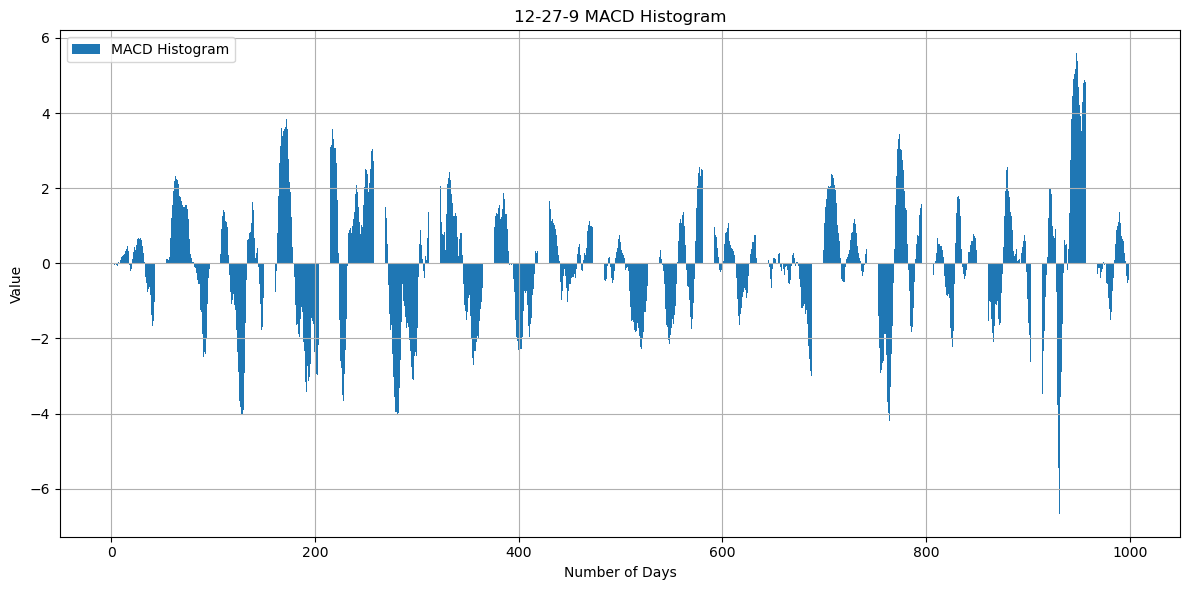

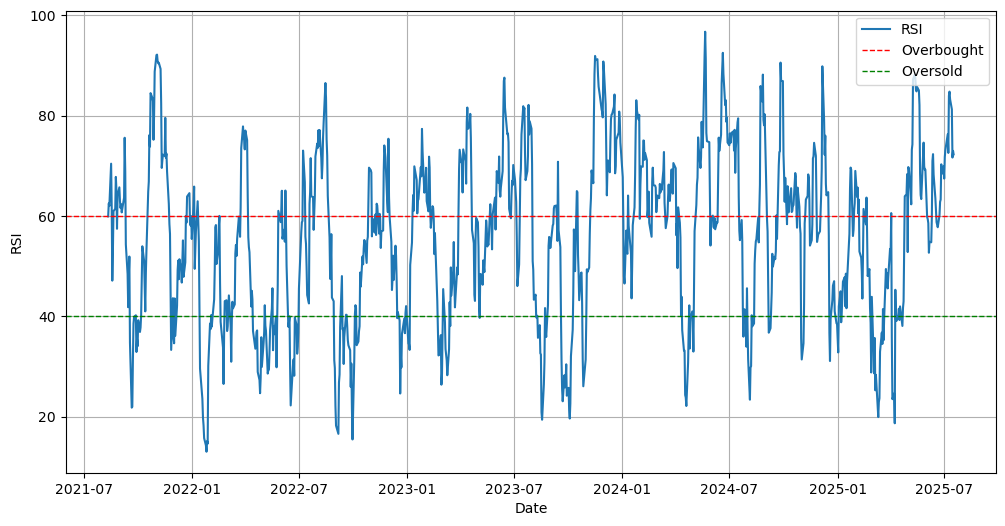

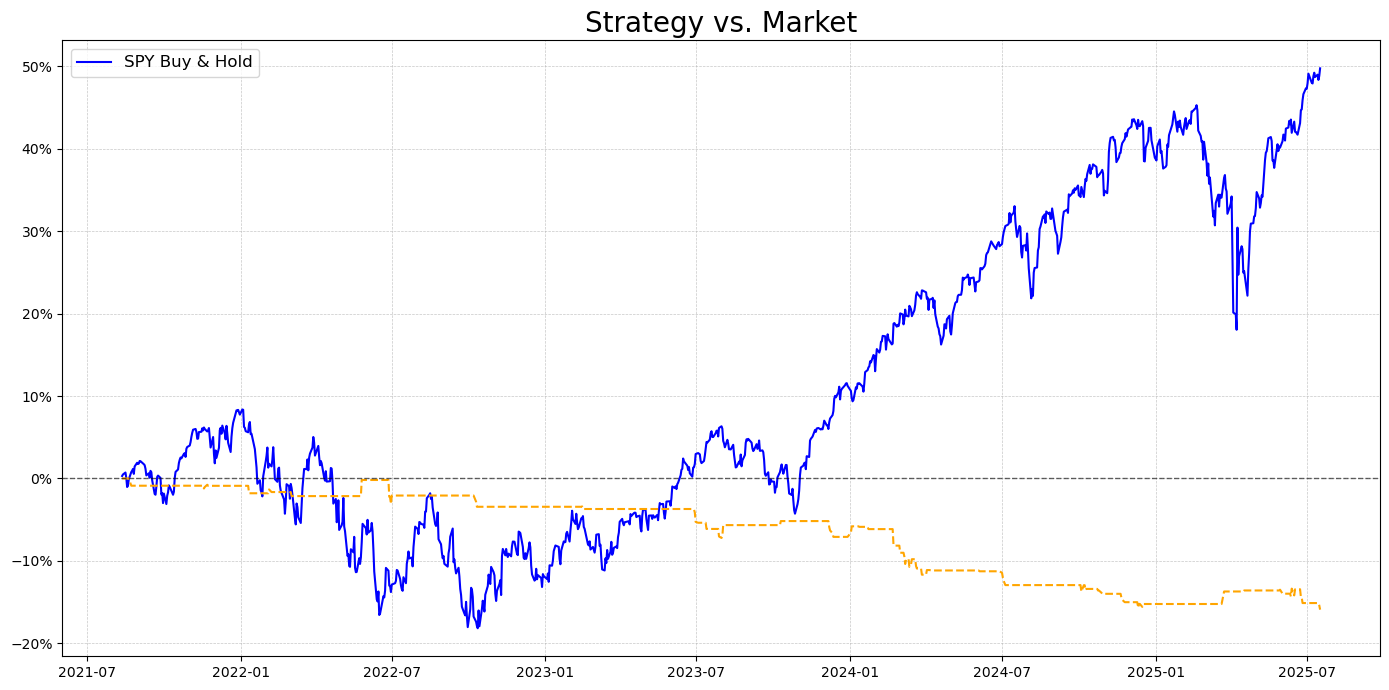

SPY Buy & Hold Return: 49.76%
SPY MACD/RSI Strategy Return over past 1000 days: -15.92%


In [5]:
def main():
    df = get_data()
    df = add_MACD(df)
    df = add_RSI(df)
    df = add_MACD_strategy(df)
    df = add_RSI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)
    return_summary(df, TICKER, LOOKBACK)  
    return 

main()